In [2]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

url ="https://www.alphavantage.co/query"

params = {
    "function":"TIME_SERIES_DAILY_ADJUSTED",
    "symbol": "AAPL",
    "apikey": "TU10HCWDTV5CNVBN"
}

response = requests.get(url, params=params)
data = response.json()

def convert_response(d):
    for dt, prec in d['Time Series (Daily)'].items():
        r = {'datetime': dt}
        r.update(prec)
        yield r

df = pd.DataFrame(convert_response(data))
# rename the columns    
df = df.rename(columns={ '1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. adjusted close': 'AdjClose', '6. volume': 'Volume'})
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
# extract the columns you want
df = df[[ 'Close']]
df.head()

,Close
datetime,
2018-06-21,185.4600
2018-06-22,184.9200
2018-06-25,182.1700
2018-06-26,184.4300
2018-06-27,184.1600


In [3]:
df.describe().transpose()

,count,unique,top,freq
Close,100,99,226.8700,2


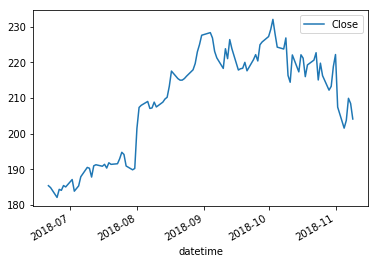

In [5]:
df=df.astype(float)
df.plot()

In [6]:
timeseries = df['Close']

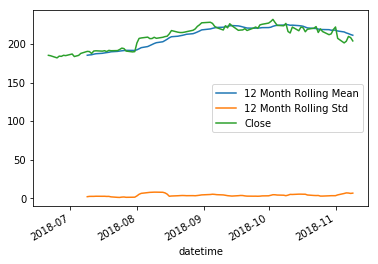

In [7]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

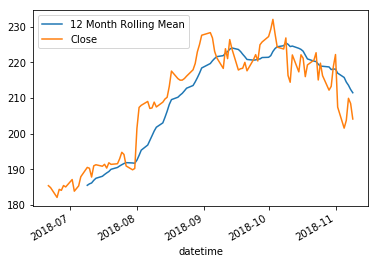

In [8]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

## Descomposiciones
## LA DESCOMPOSICION ETS nos permite ver las partes 

<Figure size 432x288 with 0 Axes>

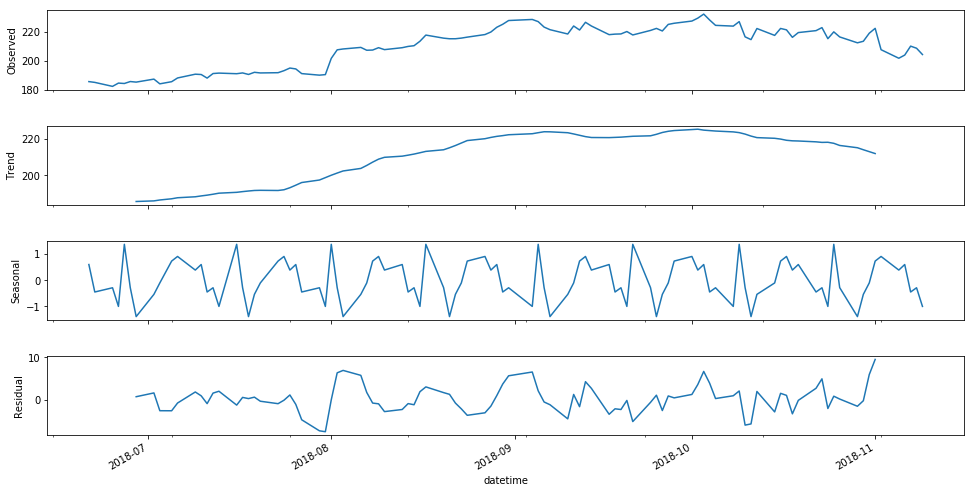

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Close'], freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

# TESTING PARA Stationarity

In [10]:
df.head()

,Close
datetime,
2018-06-21,185.46
2018-06-22,184.92
2018-06-25,182.17
2018-06-26,184.43
2018-06-27,184.16


In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
result = adfuller(df['Close'])

In [13]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used']

for value, label in zip(result,labels):
    print(label+' : '+str(value))
    
if result[1] <= 0.05:
    print("Los datos no tienen raíz unitaria y son estacionarios.")
else:
    print("evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.9034872363428412
p-value : 0.3304223872561822
#lags Used : 2
Number of Observations Used : 97
evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria


In [14]:
# Store in a function for later use:

def adf_check(time_series):
    """
        Pasar en una serie de tiempo, regresar reporteADF
    """
    
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("evidencia fuerte contra la hipótesis nula, rechazar hipótesis nula. Los datos no tienen una raíz unitaria, lo que indica que es estacionaria")
    else:
        print("evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria")

In [15]:
df['Close First Difference'] = df['Close'] - df['Close'].shift(1)

In [16]:
adf_check(df['Close First Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -8.66944617535456
p-value : 4.588614056109715e-14
# Lags Used : 1
Number of Observations Used : 97
evidencia fuerte contra la hipótesis nula, rechazar hipótesis nula. Los datos no tienen una raíz unitaria, lo que indica que es estacionaria


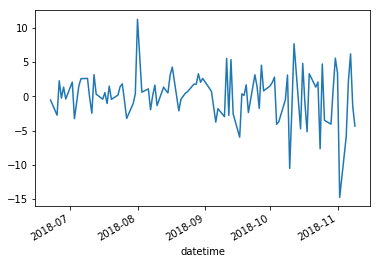

In [17]:
df['Close First Difference'].plot()

In [18]:
# Sometimes it would be necessary to do a second difference
# This is just for show, we didn't need to do a second difference in our case
df['Close Second Difference'] = df['Close First Difference'] - df['Close First Difference'].shift(1)

In [19]:
adf_check(df['Close Second Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -8.185195690177054
p-value : 7.934247163205013e-13
# Lags Used : 5
Number of Observations Used : 92
evidencia fuerte contra la hipótesis nula, rechazar hipótesis nula. Los datos no tienen una raíz unitaria, lo que indica que es estacionaria


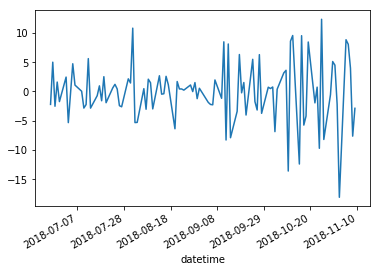

In [20]:
df['Close Second Difference'].plot()

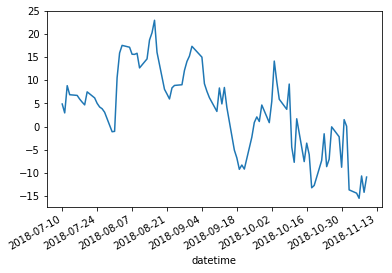

In [21]:
df['Seasonal Difference'] = df['Close'] - df['Close'].shift(12)
df['Seasonal Difference'].plot()

In [22]:
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -0.1485581097485892
p-value : 0.9443819933460662
# Lags Used : 12
Number of Observations Used : 75
evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria


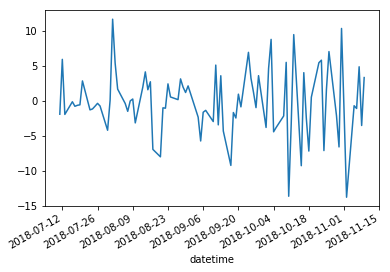

In [23]:
df["Seasonal First Difference"] = df["Close First Difference"] - df["Close First Difference"].shift(12)
df["Seasonal First Difference"].plot()

In [24]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -4.25639475217109
p-value : 0.0005281217407099543
# Lags Used : 11
Number of Observations Used : 75
evidencia fuerte contra la hipótesis nula, rechazar hipótesis nula. Los datos no tienen una raíz unitaria, lo que indica que es estacionaria


## ARIMA

In [25]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [26]:
# tenemos los datos estacionarios:
model = sm.tsa.statespace.SARIMAX(df['Close'],xlim=['2018-0-09', '2018-11-02'], order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Close   No. Observations:                  100
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -247.777
Date:                            Fri, 09 Nov 2018   AIC                            501.554
Time:                                    14:19:07   BIC                            508.951
Sample:                                         0   HQIC                           504.533
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0939      0.216      0.435      0.664      -0.329       0.517
ma.S.L12      -0.6962      0.240   

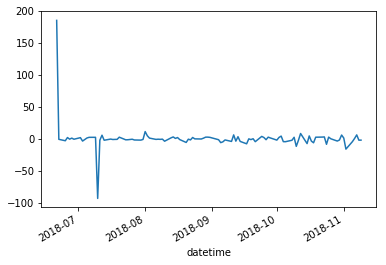

In [27]:
results.resid.plot()

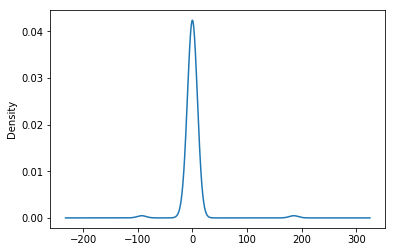

In [28]:
results.resid.plot(kind='kde')

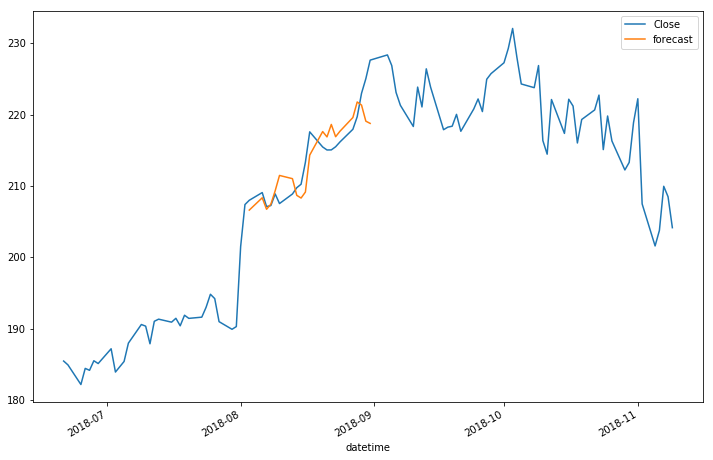

In [30]:
df['forecast'] = results.predict(start= 30, end =50 , dynamic= True)
df[['Close', 'forecast']].plot(figsize=(12, 8))

In [29]:
len(df)

100

In [45]:
df.tail()

,Close,Close First Difference,Close Second Difference,Seasonal Difference,Seasonal First Difference,forecast
datetime,,,,,,
2018-11-02,207.48,-14.74,-18.10,-13.71,-13.78,220.294322
2018-11-05,201.59,-5.89,8.85,-14.43,-0.72,218.674391
2018-11-06,203.77,2.18,8.07,-15.54,-1.11,219.981311
2018-11-07,209.95,6.18,4.00,-10.70,4.84,219.743379
2018-11-08,208.49,-1.46,-7.64,-14.24,-3.54,220.115966


## Datos Futuros

In [87]:
from pandas.tseries.offsets import DateOffset

In [111]:
future_dates = [df.index[-1] + DateOffset(x) for x in range(0,5)]

In [112]:
future_dates

[Timestamp('2018-11-08 00:00:00'),
 Timestamp('2018-11-09 00:00:00'),
 Timestamp('2018-11-10 00:00:00'),
 Timestamp('2018-11-11 00:00:00'),
 Timestamp('2018-11-12 00:00:00')]

In [113]:
future_dates_df = pd.DataFrame(index=future_dates[1:], columns=df.columns)

In [114]:
future_df = pd.concat([df, future_dates_df])

In [115]:
future_df


,Close,Close First Difference,Close Second Difference,Seasonal Difference,Seasonal First Difference,forecast
2018-06-20,186.50,NaN,NaN,NaN,NaN,NaN
2018-06-21,185.46,-1.04,NaN,NaN,NaN,NaN
2018-06-22,184.92,-0.54,0.50,NaN,NaN,NaN
2018-06-25,182.17,-2.75,-2.21,NaN,NaN,NaN
2018-06-26,184.43,2.26,5.01,NaN,NaN,NaN
2018-06-27,184.16,-0.27,-2.53,NaN,NaN,NaN
2018-06-28,185.50,1.34,1.61,NaN,NaN,NaN
2018-06-29,185.11,-0.39,-1.73,NaN,NaN,NaN
2018-07-02,187.18,2.07,2.46,NaN,NaN,NaN
2018-07-03,183.92,-3.26,-5.33,NaN,NaN,NaN


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


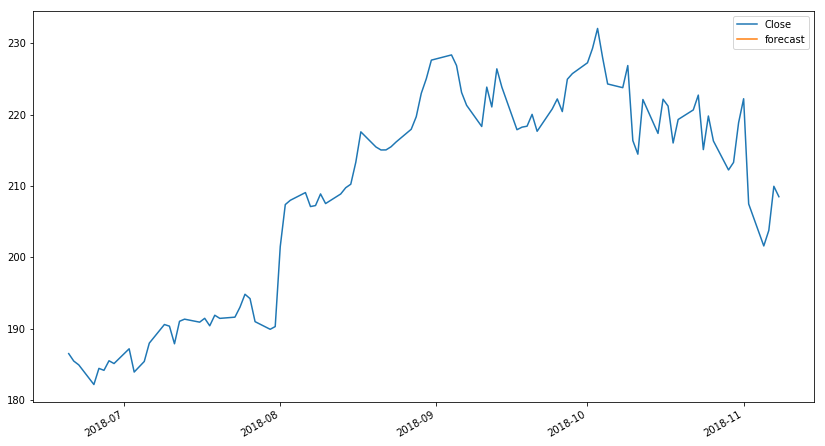

In [118]:
future_df['forecast'] = results.predict(start = 90, end= 100, dynamic = True)
future_df[['Close', 'forecast']].plot(figsize=(14,8), xlim=['2018-07-09', '2009-01-01'])
#future_df['forecast']

In [117]:
future_df.tail()

,Close,Close First Difference,Close Second Difference,Seasonal Difference,Seasonal First Difference,forecast
2018-11-08,208.49,-1.46,-7.64,-14.24,-3.54,220.115966
2018-11-09,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-10,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-11,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-12,NaN,NaN,NaN,NaN,NaN,NaN
